# Machine Learning: Assignment 1

### Topics:
- Naïve bayes
- Gaussian Bayes
- Parzen Windows
- KNN

 by:
Dema Omar,Aya Fodi

## Part 1 – Bayesian Classification Assuming Gaussian Distribution

### 1. Introduction
The *Central Bank of America* aims to automatically detect and classify banknotes into three quality categories: **fake**, **fine**, and **good**.  

Each banknote is represented by five continuous numerical features extracted from digitized images.  
Because the data is continuous, I applied two probabilistic classification models based on the **Gaussian (normal) distribution**:

1. **Gaussian Bayes (GB)** – models each class as a full multivariate Gaussian distribution, allowing correlations between features.  
2. **Gaussian Naïve Bayes (GNB)** – assumes that all features are independent, simplifying the model by treating each feature separately.  

The main objectives of this experiment are to:
- Implement both classifiers.  
- Compare their performance on the same dataset.  
- Analyze how feature correlations influence model accuracy.






import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Weload the wine dataset from https://sharon.srworkspace.com/ml/datasets/hw1/banknote_authentication.csv

In [ ]:
# Implement here

from pandas import read_csv
path="https://sharon.srworkspace.com/ml/datasets/hw1/banknote_authentication.csv"
headernames=['contrast','skew','curtosis','heat','cent_col','Class']
df= read_csv(path,names=headernames,skiprows=1)

print(df.shape)
df.head(3)

(600, 6)


,contrast,skew,curtosis,heat,cent_col,Class
0,2.446909,2.702995,0.832495,0.531505,-1.734316,0
1,0.870104,2.248493,-1.496408,1.383379,-1.216271,0
2,-1.930227,-2.708964,1.031232,-0.125341,0.683788,2


The resulting graphs show that the feature values are concentrated around specific central regions, with density gradually decreasing as we move away from those centers.  
This bell shaped pattern is characteristic of Gaussian (normal) distributions, indicating that the assumption of normality is reasonable for this dataset.  
Therefore,applying Gaussian Bayes models is expected to be suitable.

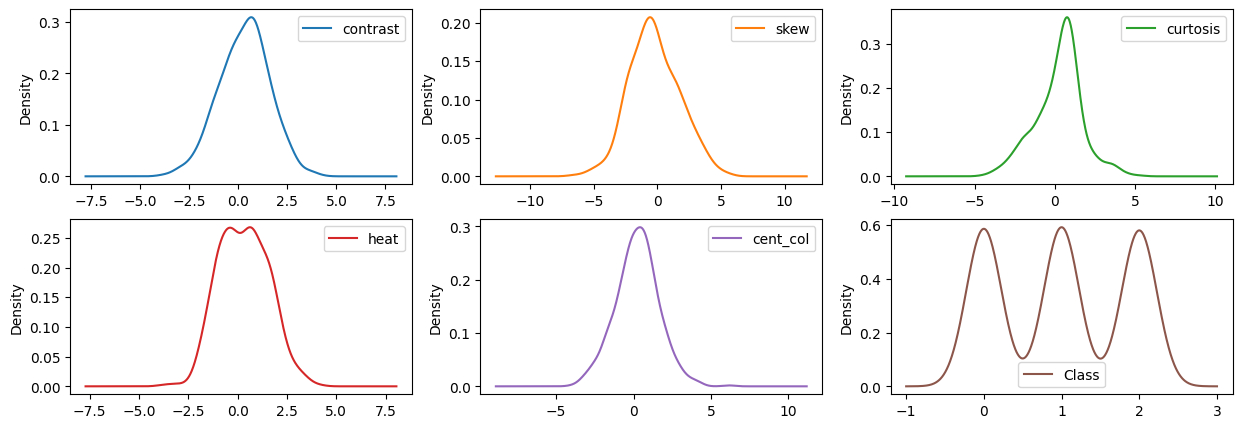

In [ ]:
df.plot(kind='density', subplots=True, layout=(2,3), figsize=(15, 5), sharex=False)
plt.show()

This code converts the dataset into NumPy arrays and splits it into **80% training** and **20% testing** sets.  
It uses a **stratified split** to keep the class distribution balanced and a fixed random state (33) for reproducibility.


In [ ]:
# Implement here
from sklearn.model_selection import train_test_split
arrData = np.array(df)
arrDataF = arrData[:,:-1]
labels = arrData[:,-1]
train , test , lbl_train , lbl_test = train_test_split(arrDataF, labels, test_size=0.2 ,shuffle=True ,random_state=33 ,stratify=labels)


### Gaussian Parameter Estimation and Classification Functions

This section defines all the helper functions used by the Bayesian classifiers.  
The functions compute the Gaussian parameters for each class :the **mean vector**, **variance**, and **covariance matrix** and use them to estimate the **class-conditional probabilities**.  

- `get_guss_parametrs()` calculates the mean, variance, and covariance for every class.  
- `get_priors()` computes the prior probability of each class based on its frequency in the training set.  
- `calc_guss()` evaluates the Gaussian probability density for independent features.  
- `calc_guss_with_colleratins()` computes the multivariate Gaussian when correlations exist.  
- `classify_point_gaussian_bayes()` predicts class labels using the full covariance matrix (Gaussian Bayes).  
- `classify_point_gaussian_naive_bayes()` predicts labels assuming feature independence (Naïve Bayes).

Both classifiers take a test matrix and return a vector of predicted class labels.


In [ ]:
def get_guss_parametrs():
  clases = np.unique(lbl_train)  # Get the unique class labels
  means_vec = np.zeros((len(clases), train.shape[1]))  # Mean vector for each class
  var_vec = np.zeros((len(clases), train.shape[1]))    # Variance vector for each class
  cov_vec = [None] * len(clases)                       # Covariance matrix list

  # Calculate mean, variance, and covariance for each class
  for i, clss in enumerate(clases):
    clss_points = train[lbl_train == clss]
    means_vec[i] = np.mean(clss_points, axis=0)
    var_vec[i] = np.var(clss_points, axis=0)
    cov_vec[i] = np.cov(clss_points.T)
  return means_vec, var_vec, cov_vec

# This function computes the prior probabilities P(Class)
def get_priors():
  clases = np.unique(lbl_train)
  priors_vec = np.zeros(len(clases))
  all_points_len = len(lbl_test)
  for i, clss in enumerate(clases):
    priors_vec[i] = (np.sum(lbl_train == clss))/all_points_len
  return priors_vec

def calc_guss(value, mean, var):
  return (1/np.sqrt(2*np.pi*var)) * np.exp(-((value - mean) ** 2)/(2 * var))

# This function computes the multivariate Gaussian probability
def calc_guss_with_colleratins(value, mean, cov):
    k = len(mean)
    diff = value - mean
    expo = -0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff)
    norm = 1 / ((2 * np.pi)**(k / 2) * np.sqrt(np.linalg.det(cov + 1e-5*np.eye(len(cov)))))
    return norm * np.exp(expo)


# Gaussian Bayes Classifier (Full Covariance)
# Uses full covariance matrices to model correlations between features
def classify_point_gaussian_bayes(test_data):
  predictions = np.zeros(test_data.shape[0])    # Placeholder for predicted labels
  priors_vec = get_priors()
  means_vec, var_vec, cov_vec = get_guss_parametrs()
  clases = np.unique(lbl_train)

# For each test sample, compute class conditional probabilities
  for i, point in enumerate(test_data):
    condition_prob = np.zeros(len(clases))
    for j ,clss in enumerate(clases):
      guss_prob = calc_guss_with_colleratins(point, means_vec[j],cov_vec[j])
      # Use log probabilities for numerical stability
      condition_prob[j] = np.log(priors_vec[j]+1e-10) + np.log(guss_prob)
    predictions[i] = np.argmax(condition_prob)  # Choose class with max log probability

  return predictions

# Gaussian Naïve Bayes Classifier (Diagonal Covariance)
# Assumes feature independence: uses individual variances instead of full covariance matrices.
def classify_point_gaussian_naive_bayes(test_data):
  predictions = np.zeros(test_data.shape[0])
  priors_vec = get_priors()
  means_vec, var_vec, cov_vec = get_guss_parametrs()
  clases = np.unique(lbl_train)
   # For each test sample, compute class conditional probabilities
  for i, point in enumerate(test_data):
    condition_prob = np.zeros(len(clases))
    for j ,clss in enumerate(clases):
      guss_prob = calc_guss(point, means_vec[j], var_vec[j])  # Independent Gaussian per feature
      condition_prob[j] = np.log(priors_vec[j] + 1e-10) + np.sum(np.log(guss_prob))
    predictions[i] = np.argmax(condition_prob)
  return predictions

### Model Comparison: Gaussian Bayes vs. Naïve Bayes

Gaussian Bayes achieved higher accuracy on both the training and testing sets.  
This is expected, since the Naïve Bayes model assumes all features are independent, while in reality some of them are correlated.  
The Gaussian Bayes model captures these correlations, leading to better learning performance.  

However, Naïve Bayes can perform better in cases where the features are truly independent, or when the dataset is small and model simplicity helps avoid overfitting.



In [ ]:
# Reminder: success rate is the precentage of correctly classified data within the number of all data in the test set.

dict1 = {'GB': [], 'GNB': []}

accs = classify_point_gaussian_bayes(train)
dict1['GB'].append(np.count_nonzero(accs == lbl_train) / len(lbl_train))

accs = classify_point_gaussian_bayes(test)
dict1['GB'].append(np.count_nonzero(accs == lbl_test) / len(lbl_test))

accs = classify_point_gaussian_naive_bayes(train)
dict1['GNB'].append(np.count_nonzero(accs == lbl_train) / len(lbl_train))

accs = classify_point_gaussian_naive_bayes(test)
dict1['GNB'].append(np.count_nonzero(accs == lbl_test) / len(lbl_test))

df = pd.DataFrame(dict1, columns=['GB', 'GNB'], index=['train', 'test'])
print(df)

/tmp/ipython-input-3438533949.py:50: RuntimeWarning: divide by zero encountered in log
  condition_prob[j] = np.log(priors_vec[j]+1e-10) + np.log(guss_prob)


             GB       GNB
train  0.945833  0.850000
test   0.916667  0.833333


###Feature Correlation and Selection

To further improve the test performance, the correlation matrix of the training data was analyzed.  
The feature **“skew”** showed a very high correlation with **“cent_col”**, meaning both features convey similar information.  
Removing one of them simplifies the model and reduces computational complexity without significantly affecting accuracy.  

If additional features were removed, the training error would likely increase, since the model would lose important information required for accurate classification.


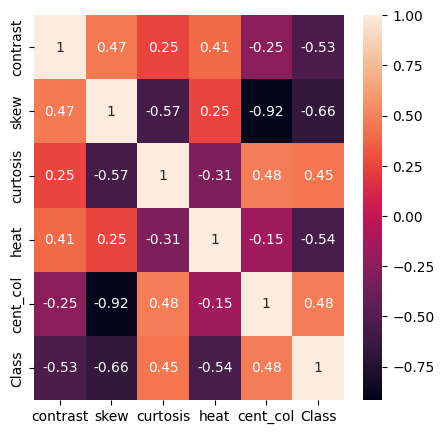

In [ ]:

import seaborn as sns
plt.subplots(figsize=(5,5))
df= read_csv(path,names=headernames,skiprows=1)
sns.heatmap(df.corr(), annot=True)
plt.show()

###Model Re-evaluation After Feature Removal

After removing the selected feature (*skew*), the models were retrained and evaluated again on both the training and testing sets.  
This step verifies how the reduced feature set affects the accuracy and generalization of each classifier:


In [ ]:
#  trainung and the test according to the feature we remove

arrDataF = np.hstack([arrData[:, :1], arrData[:, 2:-1]])
labels = arrData[:,-1]
train , test , lbl_train , lbl_test = train_test_split(arrDataF, labels, test_size=0.2 ,shuffle=True ,random_state=33 ,stratify=labels)

dict1 = {'GB': [], 'GNB': []}

accs = classify_point_gaussian_bayes(train)
dict1['GB'].append(np.count_nonzero(accs == lbl_train) / len(lbl_train))

accs = classify_point_gaussian_bayes(test)
dict1['GB'].append(np.count_nonzero(accs == lbl_test) / len(lbl_test))

accs = classify_point_gaussian_naive_bayes(train)
dict1['GNB'].append(np.count_nonzero(accs == lbl_train) / len(lbl_train))

accs = classify_point_gaussian_naive_bayes(test)
dict1['GNB'].append(np.count_nonzero(accs == lbl_test) / len(lbl_test))

df = pd.DataFrame(dict1, columns=['GB', 'GNB'], index=['train', 'test'])
print(df)

             GB       GNB
train  0.952083  0.850000
test   0.941667  0.833333


<ipython-input-209-809f39902ae9>:41: RuntimeWarning: divide by zero encountered in log
  condition_prob[j] = np.log(priors_vec[j]+1e-10) + np.log(guss_prob)


Runing the boundaries plotting for (scaled) train and test with gaussian bayes.<br/>It will show the decision boundaries as saw in the lectures:

In [ ]:
# Essential for the visualization

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(train)
x_test = sc.transform(test)

(8178, 4)


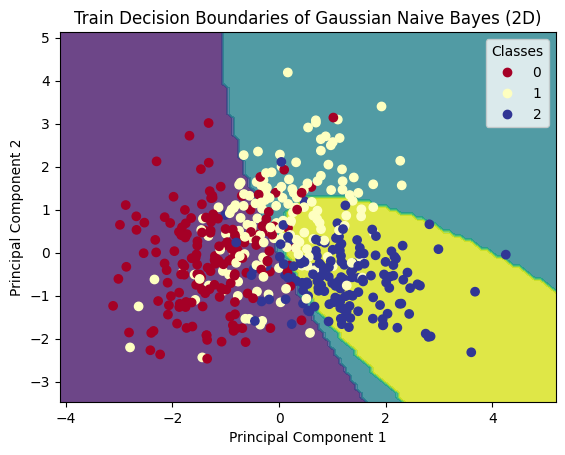

In [ ]:
#@title Train Decision Boundaries of Gaussian Naive Bayes (2D)

from sklearn.decomposition import PCA
from tqdm import tqdm

# Reduce the dimensionality of the data to 2 using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_train)

# Create a grid of points for visualization in the reduced 2D space
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Use the GNB model to predict class labels for the grid points in the original 13D space
grid_points = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
print(grid_points.shape)
Z = classify_point_gaussian_naive_bayes(grid_points)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and the data points in the reduced 2D space
plt.contourf(xx, yy, Z, alpha=0.8)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=lbl_train, cmap=plt.cm.RdYlBu)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title='Classes')

plt.title('Train Decision Boundaries of Gaussian Naive Bayes (2D)')
plt.show()

(6612, 4)


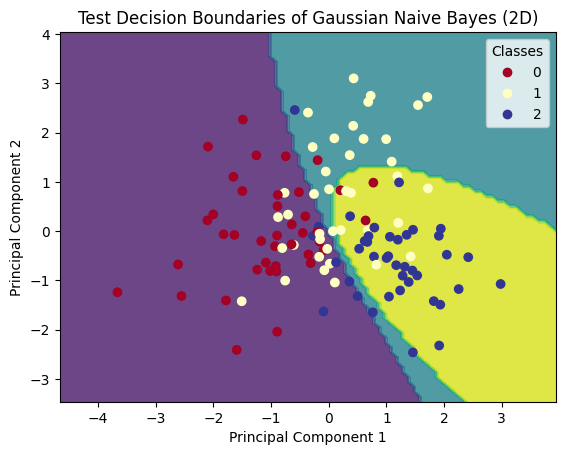

In [ ]:
#@title Train Decision Boundaries of Gaussian Naive Bayes (2D)

from sklearn.decomposition import PCA
from tqdm import tqdm

# Reduce the dimensionality of the data to 2 using PCA
X_reduced = pca.transform(x_test)

# Create a grid of points for visualization in the reduced 2D space
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Use the GNB model to predict class labels for the grid points in the original 13D space
grid_points = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
print(grid_points.shape)
Z = classify_point_gaussian_naive_bayes(grid_points)
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and the data points in the reduced 2D space
plt.contourf(xx, yy, Z, alpha=0.8)
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=lbl_test, cmap=plt.cm.RdYlBu)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add a legend
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title='Classes')

plt.title('Test Decision Boundaries of Gaussian Naive Bayes (2D)')
plt.show()

## Part 2 – Naïve Bayes for Emotion Classification

In this part, a basic **Naïve Bayes classifier** is implemented to predict human emotions from text descriptions.  
The task involves classifying each input sentence into one of six possible emotional categories:  
**{sadness, joy, love, fear, anger, ambiguous}**.  

The goal is to apply probabilistic text classification techniques, analyze the model’s assumptions, and evaluate its ability to generalize across different emotional contexts.



In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

Data Loading and Preprocessing

A custom function was implemented to read all tweets from the input file and extract the necessary data structures for training.  
The function returns:

•	texall - list of documents; each entry corresponds to a tweet which is list of words. <br/>
•	lbAll list of tweets' labels.<br/>
•	voc - set of all distinct words in the file.<br/>
•	cat - set of tweets categories.


In [ ]:

def readTrainData(file_name):
 df = pd.read_csv(file_name)

 texAll = [ row['text'] for index, row in df.iterrows() ]       # Extract all tweet texts into a list
 lbAll = [ row['label'] for index, row in df.iterrows() ]       # Extract all tweet labels into a list

 # Create a CountVectorizer to extract unique category labels
 vec_c = CountVectorizer()
 X_c = vec_c.fit_transform(lbAll)
 cat = vec_c.get_feature_names_out()

 # Create another CountVectorizer to extract the vocabulary of words from tweets
 vec_v = CountVectorizer()
 X_v = vec_v.fit_transform(texAll)
 voc = vec_v.get_feature_names_out()
 return texAll, lbAll, voc, cat, len(voc)


Probability Estimation:

This section defines a function that computes the key probabilities required for the Naïve Bayes classifier using the training data.  
Specifically, it calculates:

- **P_w** – a matrix of class-conditional probabilities, \( P(x|w_i) \), representing the likelihood of each word given a class.  
- **P** – a vector of prior probabilities, \( P(w_i) \), representing the overall frequency of each class in the dataset.  

The implementation also handles cases where a word appears in the global vocabulary but not in a specific class, by applying smoothing to prevent zero probabilities.


In [ ]:
def learn_NB_text(fileName, voc, cat):
    # Initialize a DataFrame for class-conditional probabilities (rows=classes, columns=words)
    Pw = pd.DataFrame(data=0, index=cat, columns=voc)

    # Initialize the class prior vector and an array to store class sizes
    P = np.zeros(len(cat))
    cats_len = np.zeros(len(cat))

    # Read the dataset from the given file
    df = pd.read_csv(fileName)
    df_len = df.shape[0]
    voc_len = len(voc)

    # Iterate through each category (class)
    for i, cat_i in enumerate(cat):
        # Select all documents (tweets) that belong to the current category
        cat_i_docs = [row['text'] for index, row in df.iterrows() if row['label'] == cat_i]
        cat_len = len(cat_i_docs)
        cats_len[i] = cat_len

        # Create a CountVectorizer using the global vocabulary
        vec_c = CountVectorizer(vocabulary=voc)
        X_c = vec_c.fit_transform(cat_i_docs)

        # Create a term-document matrix (TDM) for the current category
        tdm_c = pd.DataFrame(X_c.toarray(), columns=vec_c.get_feature_names_out())

        # Calculate total occurrences of each word in the current category
        column_sums = tdm_c.sum(axis=0)
        sum_cat_i = pd.DataFrame([column_sums], columns=vec_c.get_feature_names_out())

        # Total number of words in the current category
        cat_i_wordNumber = sum_cat_i.sum(axis=1)[0]

        # Compute conditional probability of each word given the category (Laplace smoothing)
        for word in sum_cat_i.columns:
            Pw.at[cat_i, word] = (sum_cat_i.at[0, word] + 1) / (cat_i_wordNumber + voc_len)

        # Compute the prior probability of the category
        P[i] = cat_len / df_len

    # Return the conditional probabilities, priors, and category sizes
    return Pw, P, cats_len


# Tweet Classification and Evaluation

This section implements the classification phase of the Naïve Bayes model.  
Each tweet in the test set is evaluated against all possible categories, and the category with the highest posterior probability is selected as the prediction.  

To avoid numerical underflow caused by multiplying many small probabilities (values between 0 and 1), all computations are performed in **log-space** using the property:  
\[
\log(xy) = \log(x) + \log(y)
\]
The model then compares the **unnormalized log-probabilities**, selecting the class with the largest score as the most probable category.  

Finally, the success rate (accuracy) is computed as the percentage of correctly classified tweets in the test set.


In [ ]:
def ClassifyNB_text(Pw, P, cats_len, texAll, lblAll, cats, voc_len):
    # Initialize a list to store the predicted class for each tweet
    classification_vec = [None] * len(texAll)
    texts = np.array(texAll)

    for i, text in enumerate(texts):
        words = text.split()       # Split the tweet into individual words
        cat_max = None             # Store the most probable class
        p_max = -np.inf            # Initialize with negative infinity

        # Compute the log-probability for each class
        for j, cat in enumerate(cats):
            p_x = np.log(P[j])     # Start with the log of the class prior

            # Sum the log-probabilities of each word given the class
            for word in words:
                if word in Pw.columns:
                    p_x += np.log(Pw.at[cat, word])
                else:
                    # Handle unseen words using Laplace smoothing
                    p_x += np.log(1 / (cats_len[j] + voc_len))

            # Keep track of the class with the highest probability
            if cat_max is None or p_x > p_max:
                cat_max = cat
                p_max = p_x

        classification_vec[i] = cat_max

    return accuracy_score(lblAll, classification_vec)


In [ ]:
 TRAIN_FILE = 'https://sharon.srworkspace.com/ml/datasets/hw1/emotions_train.csv'
 TEST_FILE = 'https://sharon.srworkspace.com/ml/datasets/hw1/emotions_test.csv'

 texAll_train, lblAll_train, voc_train, cat_train ,voc_len = readTrainData(TRAIN_FILE)
 Pw = pd.DataFrame(data=0, index=cat_train, columns=voc_train)
 P = np.zeros(len(cat_train))
 # cats must be the same at train and test
 # voc of test is irrelevant - we already trained on other voc.
 texAll_test, lblAll_test, voc_test, cat_test ,voc_len = readTrainData(TEST_FILE)

In [ ]:
 Pw, P ,cats_len = learn_NB_text(TRAIN_FILE, voc_train, cat_train)
 sum_right = ClassifyNB_text(Pw, P, cats_len, texAll_test, lblAll_test ,  cat_test, voc_len)
 print(sum_right)

0.8035


## Part 3 – K-Nearest Neighbors (KNN) for Star Classification

In this section, the **K-Nearest Neighbors (KNN)** algorithm is applied to classify stars into six different types based on their physical properties.  
The dataset provided by **NASA** includes several key attributes such as temperature, color, and spectral class, among others.  

The objective of this experiment is to analyze how well KNN can distinguish between different star categories and to compare multiple distance metrics in order to identify which one provides the most accurate classification for this dataset.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Here we load the data and print the first three rows<br/>
https://sharon.srworkspace.com/ml/datasets/hw1/Stars.csv

In [ ]:
# Implement here
df = pd.read_csv("https://sharon.srworkspace.com/ml/datasets/hw1/Stars.csv")
print(df.head(3))

   Temperature       L       R    A_M Color Spectral_Class  Type
0         3068  0.0024  0.1700  16.12   Red              M     0
1         3042  0.0005  0.1542  16.60   Red              M     0
2         2600  0.0003  0.1020  18.70   Red              M     0


Converting categorial features to discerete values

In [ ]:
colors = df['Color'].unique()
for idx, color in enumerate(colors):
  df['Color'] = df['Color'].replace({color: idx})

spec_class = df['Spectral_Class'].unique()
for idx, spec in enumerate(spec_class):
  df['Spectral_Class'] = df['Spectral_Class'].replace({spec: idx})
df.head(3)


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.0024,0.1700,16.12,0,0,0
1,3042,0.0005,0.1542,16.60,0,0,0
2,2600,0.0003,0.1020,18.70,0,0,0


>We see that there are many correlations, this means that there is complexity in the correlations. Mahalanobis distance considers these correlations, and when they are complex (as in our case), it may perform poorly. Therefore Euclidean distance will do better because of its simplicity. It's important to scale here because it does not consider correlations.</font>

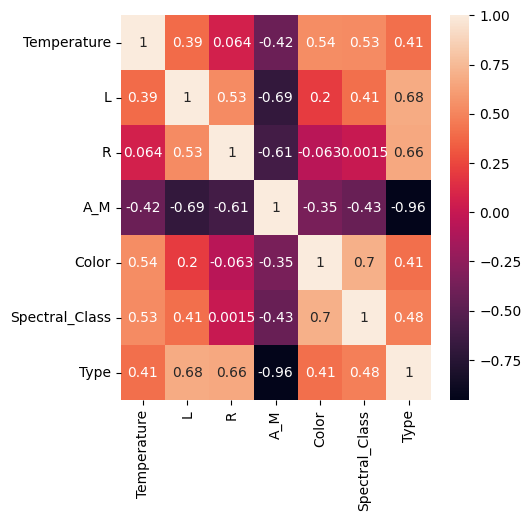

In [ ]:
import seaborn as sns
plt.subplots(figsize=(5,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Data Splitting and Balance Verification

The dataset is divided into three subsets to enable proper training, validation, and testing of the KNN model.  
First, the data is split into **90% training** and **10% testing** using a fixed random state (42) for reproducibility.  
Then, the training set is further divided into **80% training** and **20% validation**, also with random state 42.  

To preserve the proportional representation of all star types across the subsets, the splitting process uses stratified sampling .  
Class balance is verified using the `value_counts()` method to ensure that all star categories remain evenly distributed in each subset.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler for normalization
min_max_scaler = MinMaxScaler()

# Convert DataFrame to NumPy arrays
arrData = np.array(df)
arrDataF = arrData[:, :-1]
labels = arrData[:, -1]

# Split into 90% train and 10% test sets
train, test, lbl_train, lbl_test = train_test_split(
    arrDataF, labels, test_size=0.1, shuffle=True, random_state=42, stratify=labels)

# Further split the training set into 80% train and 20% validation
train, val, lbl_train, lbl_val = train_test_split(
    train, lbl_train, test_size=0.2, shuffle=True, random_state=42, stratify=lbl_train)

# Normalize all subsets to the range [0, 1]
train = min_max_scaler.fit_transform(train)
val = min_max_scaler.fit_transform(val)
test = min_max_scaler.fit_transform(test)

# Convert label arrays to integer type
lbl_train = lbl_train.astype(int)
lbl_test = lbl_test.astype(int)
lbl_val = lbl_val.astype(int)

# Convert labels to Pandas Series for easy inspection
lbl_train_series = pd.Series(lbl_train)
lbl_test_series = pd.Series(lbl_test)
lbl_val_series = pd.Series(lbl_val)

# Check class balance across the three subsets
print(lbl_train_series.value_counts())
print(lbl_test_series.value_counts())
print(lbl_val_series.value_counts())


5    29
1    29
0    29
2    29
4    28
3    28
Name: count, dtype: int64
2    4
1    4
0    4
5    4
3    4
4    4
Name: count, dtype: int64
4    8
3    8
5    7
0    7
1    7
2    7
Name: count, dtype: int64


Distance Metric Functions

Two distance metric functions are implemented to measure similarity between data samples:

- **Euclidean distance** – computes the standard straight-line distance between two points in the feature space.  
- **Mahalanobis distance** – accounts for correlations between features using the covariance matrix, providing a more adaptive measure of distance.

Both functions return an \( m \times n \) distance matrix, where each entry represents the distance between one test sample and one training sample.  
These matrices are later used by the KNN algorithm to determine the nearest neighbors for classification:



In [ ]:
def Euclidean(test, data):
    # Initialize an empty distance matrix
    distances = np.zeros((test.shape[0], data.shape[0]))

    # Compute Euclidean distance between each test and train sample
    for i in range(test.shape[0]):
        for j in range(data.shape[0]):
            distances[i, j] = np.sqrt(np.sum((test[i] - data[j]) ** 2))

    # Return the matrix of Euclidean distances
    return distances


def Mahalanobis(test, data):
    # Initialize an empty distance matrix
    distances = np.zeros((test.shape[0], data.shape[0]))

    # Compute covariance matrix of the training data
    covariance_matrix_data = np.cov(data, rowvar=False)

    # Compute Mahalanobis distance for each pair (test, train)
    for i in range(test.shape[0]):
        for j in range(data.shape[0]):
            diff = test[i] - data[j]
            distances[i, j] = np.sqrt(np.dot(np.dot(diff, np.linalg.inv(covariance_matrix_data)), diff.T))

    # Return the matrix of Mahalanobis distances
    return distances


Implement the function kNN_classify that returns array sized m, which are the predictions for the m test samples:

In [ ]:
def kNN_classify(data, labels, test, k, metric='Euclidian', p=0):
    # Prepare arguments for the distance function
    if p == 0:
        arguments = (test, data)
    else:
        arguments = (test, data, p)

    # Compute pairwise distances between test and train samples using the chosen metric
    distances = eval(f'{metric}(*arguments)')

    # Initialize an array to store predicted labels for all test samples
    predection_vec = np.zeros(test.shape[0], dtype=int)
    k_nearest = np.zeros(k, dtype=int)

    for i_test in range(test.shape[0]):
        # Sort distances and get indices of the k nearest neighbors
        index_sorted = np.argsort(distances[i_test])
        k_nearest = labels[index_sorted[:k]]

        # Count how many times each class appears among the neighbors
        counts_vec = np.bincount(k_nearest)

        # Choose the class with the highest frequency
        max_frequnted = np.argmax(counts_vec)
        predection_vec[i_test] = max_frequnted

    # Return the predicted class labels for all test samples
    return predection_vec


### Performance Comparison: Mahalanobis vs. Euclidean Distance

The KNN model was evaluated using both **Mahalanobis** and **Euclidean** distance metrics for various values of *k*.  
The analysis focuses on how the classification accuracy changes as *k* increases.

When *k* is small, the **Mahalanobis distance** often yields superior classification performance because it accounts for correlations among features.  
This property allows it to capture the local geometric structure of the data, making it especially effective in small neighborhoods where feature relationships are crucial.  
However, as *k* grows, the advantage of Mahalanobis distance tends to diminish. Over larger neighborhoods, the detailed feature correlations it models may become less relevant, and sensitivity to noise can increase, leading to reduced accuracy.

In contrast, the **Euclidean distance**—especially after appropriate feature scaling—generally performs better for moderate or larger *k* values.  
Unlike Mahalanobis distance, it does not assume a normal distribution and treats all features equally, making it more robust to noise and less dependent on correlations that may not hold across the entire dataset.

Overall, empirical results indicate that the optimal range for *k* typically lies between **7 and 13**, providing a balance between capturing meaningful local structure and avoiding excessive noise in the neighborhood.


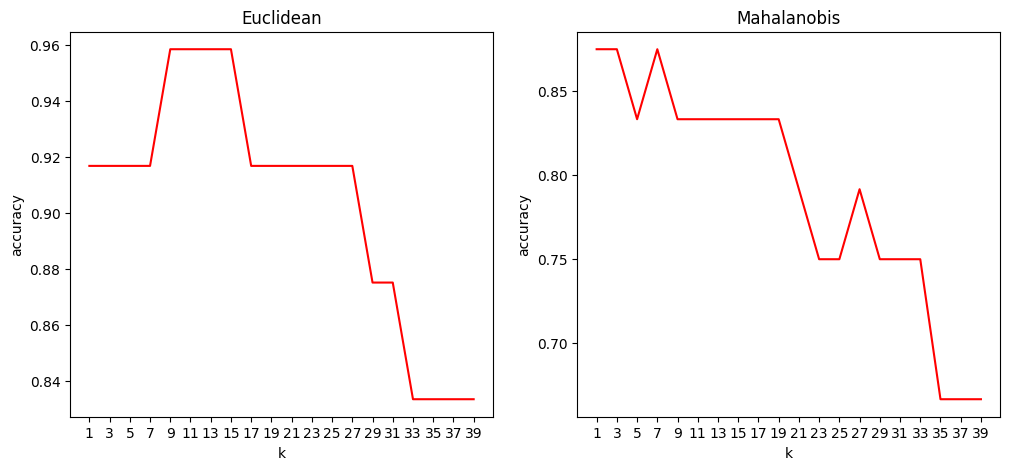

In [ ]:
metrics = ['Euclidean', 'Mahalanobis']

# Create a figure with two subplots (one for each distance metric)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for idx, metric in enumerate(metrics):

    # Define a range of k values (odd numbers from 1 to 39)
    ks = np.arange(1, 41, 2)
    accs = []

    # Evaluate KNN for each k value
    for k in ks:
        # Perform classification using the selected distance metric
        c = kNN_classify(train, lbl_train, test, k, metric)

        # Compute accuracy for the current k
        accs.append(accuracy_score(lbl_test, c))

    # Plot accuracy vs k for the current metric
    axs[idx % 2].plot(ks, accs, color='red')
    axs[idx % 2].set_xlabel('k')
    axs[idx % 2].set_ylabel('Accuracy')
    axs[idx % 2].set_title(metric)
    axs[idx % 2].set_xticks(ks)

plt.show()


Now, we implement the $L_p$ norm distance metric. Reminder:
$$ d(x,y)=||x-y||_p=\left(\sum_{i=1}^d |x_i-y_i|^p\right)^{\frac{1}{p}} $$
Remark: $L_1$ is the Manhattan distance and $L_2$ is the Euclidian.

In [ ]:
def Minkowski(test, data, p):
  distances = np.zeros((test.shape[0], data.shape[0]))

   # Compute the Minkowski distance between each test and train sample
  for i in range(test.shape[0]):
    for j in range(data.shape[0]):
      distances[i,j] = (np.sum((abs(test[i]-data[j]))**p))**(1/p)
  return distances

This step aims to identify the optimal value of the Minkowski hyperparameter "p" (ranging from 1 to 10) that provides the best classification performance for this dataset:


In [ ]:
max_accurancy_p = 0      # Store the best Minkowski parameter
max_accurancy = 0        # Store the highest accuracy found
arr_p = []

# Range of k values to test
ks = np.arange(1, 41, 5)

for k_idx in ks:
    for i in range(1, 11):
        # Run KNN classification using Minkowski distance with parameter p = i
        c = kNN_classify(train, lbl_train, val, k_idx, 'Minkowski', i)

        # Compute validation accuracy
        accurancy = accuracy_score(lbl_val, c)

        # Update maximum accuracy and best p if current one is better
        if accurancy > max_accurancy:
            max_accurancy = accurancy
            max_accurancy_p = i

    # Store the best p found for this value of k
    arr_p.append(max_accurancy_p)

print(max(arr_p))


1


After identifying the best value of **p**, the model is evaluated on the test set while varying the number of neighbors (k).  
The goal is to observe how accuracy changes with different *k* values and to compare the performance of the optimized Minkowski metric against the previous distance metrics.
The results show that the Minkowski distance behaves similarly to the Euclidean distance when \( k \) is in the range of approximately 1–29, indicating comparable performance between the two metrics under these conditions.


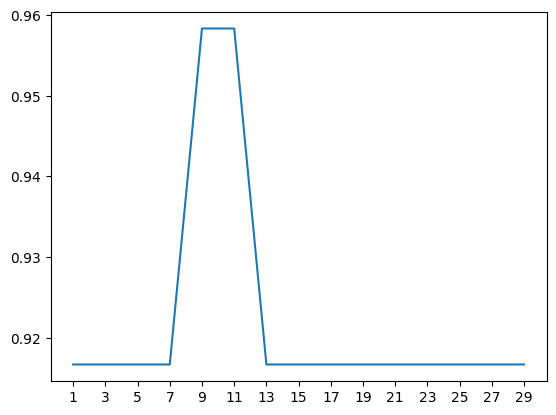

In [ ]:
ks = np.arange(1, 30, 2)
accs = []
best_p = max(arr_p)

# Evaluate KNN performance for each k using the best p
for k in ks:

    # Classify test samples using KNN with Minkowski distance
    c = kNN_classify(train, lbl_train, test, k, 'Minkowski',best_p)

    # Calculate accuracy for this k and store it
    accs.append(accuracy_score(lbl_test, c))

plt.plot(ks, accs)
plt.xticks(ks)
plt.show()

We are going to classify the fashion MNIST data.<br/>
First,we load the the train and test from:
- https://sharon.srworkspace.com/ml/datasets/hw1/fashion-mnist_train.csv
- https://sharon.srworkspace.com/ml/datasets/hw1/fashion-mnist_test.csv

Seconly, we convert it to numpy and obtain the train and test data & labels

In [ ]:
df = pd.read_csv("https://sharon.srworkspace.com/ml/datasets/hw1/fashion-mnist_train.csv")
train =   df.drop('label', axis=1).values
lbl_train =  df['label'].values


df2 = pd.read_csv("https://sharon.srworkspace.com/ml/datasets/hw1/fashion-mnist_test.csv")
test =   df2.drop('label', axis=1).values
lbl_test =  df2['label'].values


dispaly some random image

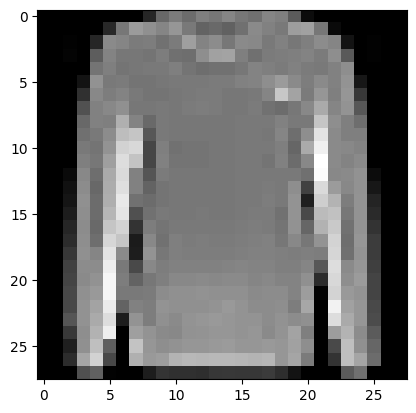

In [ ]:
idx = np.random.randint(len(train))
plt.imshow(train[idx].reshape(28,28), cmap='gray')
plt.show()

Acourding to our data the cloths types look clearly different and the photos are consistently edited, therefore Euclidean distance is effective method to see differences based on the pixel values in the photos, making it suitable for collections of images that meet these conditions.</font>

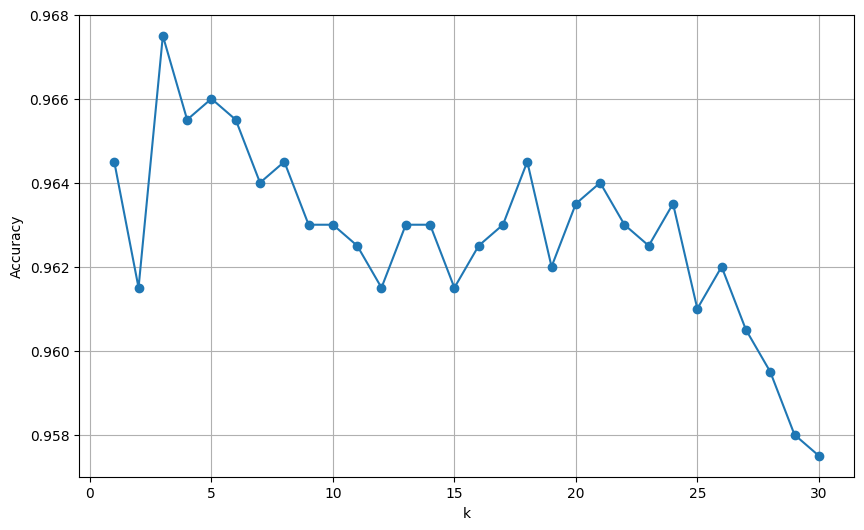

Best k: 3
Best accurancy : 0.9675


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

ks = range(1, 31)
accur_vec = []

for k in ks:
  # Initialize a KNN classifier with k neighbors using Euclidean distance
  knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

  # Train the classifier on the training data
  knn.fit(train, lbl_train)

  # Predict labels for the test set
  lbl_pre = knn.predict(test)

  accuracy = accuracy_score(lbl_test, lbl_pre)
  accur_vec.append(accuracy)


plt.figure(figsize=(10, 6))
plt.plot(ks, accur_vec, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

max_k = ks[np.argmax(accur_vec)]
max_accuracy = max(accur_vec)
print(f"Best k: {max_k}")
print(f"Best accurancy : {max_accuracy}")


